## Comparing WIS of our log-normals approach with COVIDhub methodology robust untrained.

### Calculating WIS for log-normals

Here we take the lognormals obtained in the notebooks *log_normal_parameters_KL_cases* and *log_normal_parameters_CDF_cases* and calculate the WIS.

In [1]:
import pandas as pd
import numpy as np
from epiweeks import Week
from numpy import log, exp
from scipy.stats import lognorm
from scipy.optimize import minimize
from matplotlib import use, get_backend
import aux_functions

import mosqlient as mosq
from itertools import product 
from mosqlient.scoring import compute_wis

from numpy.typing import NDArray

#use('TkAgg', force=True)
from matplotlib import pyplot as plt
#print("Switched to:", get_backend())

In [2]:
df_CDF = pd.read_csv('results/preds_CDF_cases_weights_equal_v3.csv')
df_KL = pd.read_csv('results/preds_KL_cases_v3.csv')

df_CDF.head()

,model,forecast_date,target_end_date,horizon,lower_95,lower_80,lower_50,pred,upper_50,upper_80,upper_95,value,mu,sigma
0,BPagano-RtDriven,2020-10-18,2020-10-24,1,252157.46981,309027.43446,360710.91108,418324.95041,475938.98974,527622.46637,584492.43102,485474.0,12.934439,0.205498
1,BPagano-RtDriven,2020-10-18,2020-10-31,2,250557.34760,325076.22060,392799.04150,468292.90380,543786.76609,611509.58699,686028.46000,572162.0,13.043683,0.241115
2,BPagano-RtDriven,2020-10-18,2020-11-07,3,236909.92449,332846.68480,420034.10156,517226.07830,614418.05504,701605.47179,797542.23210,777428.0,13.138261,0.281946
3,BPagano-RtDriven,2020-10-18,2020-11-14,4,213876.19851,330803.52595,437067.18958,555524.36963,673981.54967,780245.21330,897172.54074,1028914.0,13.204400,0.321069
4,BPagano-RtDriven,2020-10-25,2020-10-31,1,299044.13571,364922.81525,424793.42033,491534.04269,558274.66504,618145.27012,684023.94966,572162.0,13.099669,0.940347


In [3]:
df_KL.head()

,model,forecast_date,target_end_date,horizon,lower_95,lower_80,lower_50,pred,upper_50,upper_80,upper_95,value,mu,sigma
0,BPagano-RtDriven,2020-10-18,2020-10-24,1,252157.46981,309027.43446,360710.91108,418324.95041,475938.98974,527622.46637,584492.43102,485474.0,12.838487,0.208747
1,BPagano-RtDriven,2020-10-18,2020-10-31,2,250557.34760,325076.22060,392799.04150,468292.90380,543786.76609,611509.58699,686028.46000,572162.0,12.925423,0.250265
2,BPagano-RtDriven,2020-10-18,2020-11-07,3,236909.92449,332846.68480,420034.10156,517226.07830,614418.05504,701605.47179,797542.23210,777428.0,12.991771,0.300785
3,BPagano-RtDriven,2020-10-18,2020-11-14,4,213876.19851,330803.52595,437067.18958,555524.36963,673981.54967,780245.21330,897172.54074,1028914.0,13.027909,0.352790
4,BPagano-RtDriven,2020-10-25,2020-10-31,1,299044.13571,364922.81525,424793.42033,491534.04269,558274.66504,618145.27012,684023.94966,572162.0,13.001782,0.205413


In [4]:
df_CDF.isnull().sum()

model               0
forecast_date       0
target_end_date     0
horizon             0
lower_95            0
lower_80            0
lower_50            0
pred                0
upper_50            0
upper_80            0
upper_95            0
value               0
mu                 14
sigma               0
dtype: int64

In [5]:
df_KL.isnull().sum()

model              0
forecast_date      0
target_end_date    0
horizon            0
lower_95           0
lower_80           0
lower_50           0
pred               0
upper_50           0
upper_80           0
upper_95           0
value              0
mu                 0
sigma              0
dtype: int64

In [6]:
df_CDF = df_CDF.dropna()
df_CDF = df_CDF.reset_index(drop=True)

#df_KL = df_KL.dropna()
#df_KL = df_KL.reset_index(drop=True)

print("CDF_len:", len(df_CDF))
print("KL_len:", len(df_KL))

CDF_len: 6777
KL_len: 6791


In [7]:
horizons = df_KL.horizon.unique()
target_end_dates = df_KL.target_end_date.unique()
print(horizons)
print(target_end_dates)

[1 2 3 4]
['2020-10-24' '2020-10-31' '2020-11-07' '2020-11-14' '2020-11-21'
 '2020-11-28' '2020-12-05' '2020-12-12' '2020-12-19' '2020-12-26'
 '2021-01-02' '2021-01-09' '2021-01-16' '2021-01-23' '2021-01-30'
 '2021-02-06' '2021-02-13' '2021-02-20' '2021-02-27' '2021-03-06'
 '2021-03-13' '2021-03-20' '2021-03-27' '2021-04-03' '2021-04-10'
 '2021-04-17' '2021-04-24' '2021-05-01' '2021-05-08' '2021-05-15'
 '2021-05-22' '2021-05-29' '2021-06-05' '2021-06-12' '2021-06-19'
 '2021-06-26' '2021-07-03' '2021-07-10' '2021-07-17' '2021-07-24'
 '2021-07-31' '2021-08-07' '2021-08-14' '2021-08-21' '2021-08-28'
 '2021-09-04' '2021-09-11' '2021-09-18' '2021-09-25' '2021-10-02'
 '2021-10-09' '2021-10-16' '2021-10-23' '2021-10-30' '2021-11-06'
 '2021-11-13' '2021-11-20' '2021-11-27' '2021-12-04' '2021-12-11'
 '2021-12-18' '2021-12-25' '2022-01-01' '2022-01-08' '2022-01-15'
 '2022-01-22' '2022-01-29' '2022-02-05' '2022-02-12' '2022-02-19'
 '2022-02-26' '2022-03-05' '2022-03-12' '2022-03-19' '2022-03-26'


### Making the pool of log-normals

In [8]:
def pool_par_gauss(
    alpha: NDArray[np.float64], m: NDArray[np.float64], v: NDArray[np.float64]
) -> tuple:
    """
    Function to get the output distribution from a logarithmic pool of lognormal (or normal) distrutions

    Parameters
    ----------
    alpha : array of float
        Weigths assigned to each distribution in the pool.
    m : array of float
        mu parameter
    v : array of float
        variance parameter
    Returns
    -------
    tuple
        A tuple containing two elements. The first one is the mu and the second one the sd parameter of the distribution.

    Notes
    ------
    The logarithmic pooling method is based on the work of Carvalho, L. M., Villela, D. A., Coelho, F. C., & Bastos, L. S. (2023).
    Bayesian inference for the weights in logarithmic pooling. Bayesian Analysis, 18(1), 223-251.
    ------
    Implementation from: https://github.com/Mosqlimate-project/Ensemble-methods/blob/fce544fef28cb959498f0383d3110fb8596697d6/methods/ensemble.py#L75
    """
    if not (len(alpha) == len(m) == len(v)):
        raise ValueError(
            "The arrays 'alpha', 'm', and 'v' must have the same length."
        )

    ws = alpha / v
    vstar = 1 / np.sum(ws)
    mstar = np.sum(ws * m) * vstar
    return mstar, np.sqrt(vstar)

In [9]:
df_logs_pool = pd.DataFrame()

for horizon, end_date in product(horizons,target_end_dates):
    aux = df_KL.loc[(df_KL.target_end_date == end_date) & (df_KL.horizon==horizon)]
    KL_mus = aux.mu.to_numpy()
    KL_sigmas = aux.sigma.to_numpy()
    KL_weights = np.ones(len(KL_mus))/len(KL_mus)
    value = aux.value.to_numpy()
    
    mu_KL, sigma_KL =  pool_par_gauss(KL_weights, KL_mus, KL_sigmas)
    
    aux = df_CDF.loc[(df_CDF.target_end_date == end_date) & (df_CDF.horizon==horizon)]
    CDF_mus = aux.mu.to_numpy()
    CDF_sigmas = aux.sigma.to_numpy()
    CDF_weights = np.ones(len(CDF_mus))/len(CDF_mus)

    mu_CDF, sigma_CDF =  pool_par_gauss(CDF_weights, CDF_mus, CDF_sigmas)

    if len(value) != 0:
        value = value[0]
        df_logs_pool = pd.concat([df_logs_pool,
                               pd.DataFrame([[end_date, horizon, value, mu_KL, sigma_KL, mu_CDF, sigma_CDF]],
                                columns = ['target_end_date', 'horizon', 'value', 'mu_KL', 'sigma_KL', 'mu_CDF', 'sigma_CDF'] 
                                )], ignore_index = True)
df_logs_pool

C:\Users\alp19\AppData\Local\Temp\ipykernel_10472\2136054426.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  vstar = 1 / np.sum(ws)
C:\Users\alp19\AppData\Local\Temp\ipykernel_10472\2136054426.py:34: RuntimeWarning: invalid value encountered in scalar multiply
  mstar = np.sum(ws * m) * vstar


,target_end_date,horizon,value,mu_KL,sigma_KL,mu_CDF,sigma_CDF
0,2020-10-24,1,485474.0,12.870322,0.186096,12.820586,0.411634
1,2020-10-31,1,572162.0,13.196711,0.140801,13.245184,0.165497
2,2020-11-07,1,777428.0,13.265113,0.185526,13.240579,0.226438
3,2020-11-14,1,1028914.0,13.631949,0.134929,13.658104,0.186324
4,2020-11-21,1,1205674.0,13.995114,0.162440,14.065055,0.268344
...,...,...,...,...,...,...,...
379,2020-07-11,4,404295.0,11.669135,0.627511,11.904886,0.522996
380,2020-07-18,4,453422.0,11.925010,0.558982,12.100944,0.969771
381,2020-07-25,4,462065.0,12.313897,0.492881,12.444544,0.455592
382,2020-08-01,4,435246.0,12.736878,0.362330,12.784144,0.430726


In [10]:
# Probabilities for which to compute quantiles
quantile_probs = [0.025, 0.1  , 0.25 , 0.5  , 0.75 , 0.9  , 0.975]
quantile_names = ['lower_95','lower_80','lower_50','pred','upper_50','upper_80','upper_95']

# Compute quantiles and add as new columns
for i in range(0,len(quantile_probs)):
    df_logs_pool[quantile_names[i]] = df_logs_pool.apply(lambda row: lognorm.ppf(quantile_probs[i], s=row['sigma_KL'], scale=np.exp(row['mu_KL'])), axis=1)
KL_wis = compute_wis(df_logs_pool,df_logs_pool.value.to_numpy())
df_logs_pool['KL_WIS'] = KL_wis

rename_map = {col: f"KL_{col}" for col in quantile_names}
df_logs_pool.rename(columns=rename_map, inplace=True)

for i in range(0,len(quantile_probs)):
    df_logs_pool[quantile_names[i]] = df_logs_pool.apply(lambda row: lognorm.ppf(quantile_probs[i], s=row['sigma_CDF'], scale=np.exp(row['mu_CDF'])), axis=1)
CDF_wis = compute_wis(df_logs_pool,df_logs_pool.value.to_numpy())
df_logs_pool['CDF_WIS'] = CDF_wis

rename_map = {col: f"CDF_{col}" for col in quantile_names}
df_logs_pool.rename(columns=rename_map, inplace=True)

df_logs_pool

,target_end_date,horizon,value,mu_KL,sigma_KL,mu_CDF,sigma_CDF,KL_lower_95,KL_lower_80,KL_lower_50,...,KL_upper_95,KL_WIS,CDF_lower_95,CDF_lower_80,CDF_lower_50,CDF_pred,CDF_upper_50,CDF_upper_80,CDF_upper_95,CDF_WIS
0,2020-10-24,1,485474.0,12.870322,0.186096,12.820586,0.411634,269838.934207,306149.923874,3.427655e+05,...,5.596476e+05,41068.812347,165016.155124,218175.737267,2.801116e+05,3.697514e+05,4.880772e+05,6.266328e+05,8.285012e+05,47795.872793
1,2020-10-31,1,572162.0,13.196711,0.140801,13.245184,0.165497,408703.557355,449668.838309,4.897948e+05,...,7.097557e+05,19847.992566,408732.165974,457298.020055,5.056285e+05,5.653405e+05,6.321042e+05,6.989094e+05,7.819543e+05,19577.532375
2,2020-11-07,1,777428.0,13.265113,0.185526,13.240579,0.226438,400908.492809,454681.123230,5.088850e+05,...,8.296316e+05,98478.790911,361048.928929,420999.510325,4.830371e+05,5.627432e+05,6.556016e+05,7.522096e+05,8.771107e+05,98157.408189
3,2020-11-14,1,1028914.0,13.631949,0.134929,13.658104,0.186324,638893.131148,700136.196926,7.598988e+05,...,1.084257e+06,95173.610137,592979.468027,672878.343185,7.534593e+05,8.543567e+05,9.687656e+05,1.084781e+06,1.230946e+06,73826.563053
4,2020-11-21,1,1205674.0,13.995114,0.162440,14.065055,0.268344,870426.126434,971832.890574,1.072550e+06,...,1.645392e+06,39919.414258,758509.039635,909962.088014,1.070953e+06,1.283441e+06,1.538089e+06,1.810209e+06,2.171657e+06,80291.654109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2020-07-11,4,404295.0,11.669135,0.627511,11.904886,0.522996,34174.553611,52310.254813,7.656425e+04,...,3.999255e+05,163542.448973,53094.773228,75708.105315,1.039984e+05,1.479880e+05,2.105844e+05,2.892748e+05,4.124783e+05,141106.320328
380,2020-07-18,4,453422.0,11.925010,0.558982,12.100944,0.969771,50484.691857,73765.458448,1.035679e+05,...,4.516194e+05,169523.940448,26909.339940,51954.992152,9.360544e+04,1.800417e+05,3.462943e+05,6.239060e+05,1.204601e+06,112464.981121
381,2020-07-25,4,462065.0,12.313897,0.492881,12.444544,0.455592,84784.497300,118449.816062,1.597642e+05,...,5.853273e+05,112704.333283,103943.261385,141588.422051,1.866988e+05,2.538615e+05,3.451852e+05,4.551621e+05,6.200082e+05,89075.731158
382,2020-08-01,4,435246.0,12.736878,0.362330,12.784144,0.430726,167162.898281,213743.756448,2.663296e+05,...,6.917855e+05,38985.344726,153267.072407,205283.407489,2.666318e+05,3.565193e+05,4.767100e+05,6.191734e+05,8.293107e+05,42906.570379


### Comparing to COVID_4weeks model and ensemble using robust untrained methodology

In [11]:
df_4weeks_WIS =  pd.read_csv("results/comparison_4weeks_WIS_cases_v3.csv")

df_4weeks_WIS.forecast_date = pd.to_datetime(df_4weeks_WIS.forecast_date)
df_4weeks_WIS.target_end_date = pd.to_datetime(df_4weeks_WIS.target_end_date)

df_4weeks_WIS.head()

,Unnamed: 0,target_end_date,model,horizon,forecast_date,wis_COVIDhub,y,lower_95_COVIDhub,lower_80_COVIDhub,lower_50_COVIDhub,...,upper_80_COVIDhub,upper_95_COVIDhub,lower_95_calculated,lower_80_calculated,lower_50_calculated,pred_calculated,upper_50_calculated,upper_80_calculated,upper_95_calculated,wis_calculated
0,0,2020-07-25,COVIDhub-4_week_ensemble,1,2020-07-20,25603.764286,462065.0,354703.0,433849.0,471764.0,...,585873.0,689024.0,389770.550000,433243.926379,456853.385250,479011.347656,480936.250000,521132.563758,546731.492201,7773.364945
1,1,2020-08-01,COVIDhub-4_week_ensemble,1,2020-07-27,11144.278571,435246.0,390056.0,413333.0,421784.0,...,513596.0,526253.0,390056.000000,413333.000000,421784.434824,454323.000000,485925.000000,513596.000000,534241.575000,11201.308763
2,2,2020-08-01,COVIDhub-4_week_ensemble,2,2020-07-20,41405.928571,435246.0,290371.0,393021.0,455740.0,...,648353.0,802663.0,363549.615832,410751.638121,456037.658439,527631.255637,564017.703948,571498.583140,651353.291898,33499.738297
3,3,2020-08-08,COVIDhub-4_week_ensemble,1,2020-08-03,19652.042857,388787.0,367977.0,389299.0,410424.0,...,482542.0,528801.0,367977.000000,389299.000000,410424.000000,434142.000000,452867.000000,482542.000000,534700.500000,19694.182143
4,4,2020-08-08,COVIDhub-4_week_ensemble,2,2020-07-27,35524.878571,388787.0,334323.0,393452.0,431745.0,...,530096.0,578910.0,370689.833617,393452.931423,431745.000000,468837.000000,499385.000000,530096.000000,578909.528346,35265.351614


In [12]:
columns_to_exclude = ['Unnamed: 0', 'forecast_date', 'model']
df_4weeks_WIS = df_4weeks_WIS.drop(columns=columns_to_exclude)
df_4weeks_WIS
#df_4weeks_WIS = df_4weeks_WIS.drop_duplicates()

,target_end_date,horizon,wis_COVIDhub,y,lower_95_COVIDhub,lower_80_COVIDhub,lower_50_COVIDhub,pred_COVIDhub,upper_50_COVIDhub,upper_80_COVIDhub,upper_95_COVIDhub,lower_95_calculated,lower_80_calculated,lower_50_calculated,pred_calculated,upper_50_calculated,upper_80_calculated,upper_95_calculated,wis_calculated
0,2020-07-25,1,25603.764286,462065.0,354703.0,433849.0,471764.0,528883.0,563543.0,585873.0,689024.0,389770.550000,433243.926379,456853.385250,479011.347656,480936.250000,521132.563758,546731.492201,7773.364945
1,2020-08-01,1,11144.278571,435246.0,390056.0,413333.0,421784.0,454323.0,485925.0,513596.0,526253.0,390056.000000,413333.000000,421784.434824,454323.000000,485925.000000,513596.000000,534241.575000,11201.308763
2,2020-08-01,2,41405.928571,435246.0,290371.0,393021.0,455740.0,537671.0,595235.0,648353.0,802663.0,363549.615832,410751.638121,456037.658439,527631.255637,564017.703948,571498.583140,651353.291898,33499.738297
3,2020-08-08,1,19652.042857,388787.0,367977.0,389299.0,410424.0,434142.0,452867.0,482542.0,528801.0,367977.000000,389299.000000,410424.000000,434142.000000,452867.000000,482542.000000,534700.500000,19694.182143
4,2020-08-08,2,35524.878571,388787.0,334323.0,393452.0,431745.0,468837.0,499385.0,530096.0,578910.0,370689.833617,393452.931423,431745.000000,468837.000000,499385.000000,530096.000000,578909.528346,35265.351614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2022-03-26,3,30335.007143,210000.0,43800.0,73298.0,106979.0,160430.0,251749.0,384326.0,607489.0,43800.000000,73298.000000,106979.000000,182774.918630,251749.000000,384325.175000,607488.232031,27142.846853
344,2022-03-26,4,44069.542857,210000.0,28738.0,45077.0,93449.0,150573.0,351379.0,452559.0,800706.0,28738.000000,45077.000000,93449.000000,178234.233286,351379.000000,452559.000000,800705.515239,40117.934639
345,2022-04-02,3,33983.485714,198718.0,25722.0,37424.0,75688.0,119458.0,180537.0,277093.0,463804.0,25722.221184,37424.427132,80698.583730,175427.729640,236771.500000,352246.464669,473069.819946,26665.502277
346,2022-04-02,4,30210.278571,198718.0,29803.0,54906.0,92434.0,179928.0,276207.0,394795.0,686156.0,29803.469850,54906.906250,92434.000000,190012.245259,276207.000000,394795.000000,686156.000000,28769.642857


In [13]:
len(df_4weeks_WIS)

348

In [14]:
len(df_logs_pool)

384

In [15]:
df_logs_pool.target_end_date = pd.to_datetime(df_logs_pool.target_end_date)
merged_df = pd.merge(df_logs_pool, df_4weeks_WIS, on=['target_end_date', 'horizon'], how='inner')  # Options: 'inner', 'outer', 'left', 'right'

In [16]:
merged_df

,target_end_date,horizon,value,mu_KL,sigma_KL,mu_CDF,sigma_CDF,KL_lower_95,KL_lower_80,KL_lower_50,...,upper_80_COVIDhub,upper_95_COVIDhub,lower_95_calculated,lower_80_calculated,lower_50_calculated,pred_calculated,upper_50_calculated,upper_80_calculated,upper_95_calculated,wis_calculated
0,2020-10-24,1,485474.0,12.870322,0.186096,12.820586,0.411634,269838.934207,306149.923874,3.427655e+05,...,422750.0,431219.0,312392.000000,332972.000000,3.607100e+05,3.884520e+05,4.053500e+05,4.227500e+05,4.312188e+05,76777.900143
1,2020-10-31,1,572162.0,13.196711,0.140801,13.245184,0.165497,408703.557355,449668.838309,4.897948e+05,...,522851.0,544569.0,388545.000000,433541.000000,4.569850e+05,4.727360e+05,4.999446e+05,5.272925e+05,5.449086e+05,62307.860089
2,2020-11-07,1,777428.0,13.265113,0.185526,13.240579,0.226438,400908.492809,454681.123230,5.088850e+05,...,639387.0,703080.0,493193.288621,521196.221336,5.465553e+05,5.686801e+05,5.984417e+05,6.350941e+05,7.030792e+05,151329.021780
3,2020-11-14,1,1028914.0,13.631949,0.134929,13.658104,0.186324,638893.131148,700136.196926,7.598988e+05,...,917712.0,947117.0,638931.000000,686279.000000,7.230710e+05,7.906580e+05,8.591050e+05,9.095735e+05,9.370257e+05,161130.332154
4,2020-11-21,1,1205674.0,13.995114,0.162440,14.065055,0.268344,870426.126434,971832.890574,1.072550e+06,...,1280910.0,1360583.0,918561.850000,988967.128280,1.037512e+06,1.146558e+06,1.237882e+06,1.265103e+06,1.347608e+06,33711.566150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2020-09-19,4,290320.0,12.135791,0.243474,12.378284,0.443390,115680.929709,136457.276475,1.581929e+05,...,299336.0,362334.0,157251.705601,174333.138858,1.823103e+05,2.123143e+05,2.856456e+05,3.360324e+05,3.674550e+05,25981.729410
344,2020-09-26,4,293916.0,11.856045,0.000159,12.411938,0.437860,140889.734786,140904.941682,1.409186e+05,...,323834.0,359334.0,153323.951575,201470.284900,2.248608e+05,2.496349e+05,2.936533e+05,3.238340e+05,3.659125e+05,16329.277534
345,2020-10-03,4,300773.0,11.987237,0.259860,11.836457,0.343662,96559.990183,115175.490898,1.348561e+05,...,331150.0,338976.0,146927.895050,187082.000000,2.213170e+05,2.612250e+05,2.963199e+05,3.115699e+05,3.369415e+05,17193.416107
346,2020-10-10,4,334603.0,11.892275,0.252785,12.141528,0.400375,89038.672983,105695.575813,1.232259e+05,...,285551.0,307812.0,148089.596000,166737.000000,1.838678e+05,2.131878e+05,2.572330e+05,2.855505e+05,3.077559e+05,70911.869920


In [17]:
sum(merged_df['y']==merged_df['value'])

348

In [18]:
len(merged_df)

348

In [19]:
merged_df = merged_df.drop(columns='value')

In [20]:
merged_df.isnull().sum()

target_end_date        0
horizon                0
mu_KL                  0
sigma_KL               0
mu_CDF                 0
sigma_CDF              0
KL_lower_95            0
KL_lower_80            0
KL_lower_50            0
KL_pred                0
KL_upper_50            0
KL_upper_80            0
KL_upper_95            0
KL_WIS                 0
CDF_lower_95           0
CDF_lower_80           0
CDF_lower_50           0
CDF_pred               0
CDF_upper_50           0
CDF_upper_80           0
CDF_upper_95           0
CDF_WIS                0
wis_COVIDhub           0
y                      0
lower_95_COVIDhub      0
lower_80_COVIDhub      0
lower_50_COVIDhub      0
pred_COVIDhub          0
upper_50_COVIDhub      0
upper_80_COVIDhub      0
upper_95_COVIDhub      0
lower_95_calculated    0
lower_80_calculated    0
lower_50_calculated    0
pred_calculated        0
upper_50_calculated    0
upper_80_calculated    0
upper_95_calculated    0
wis_calculated         0
dtype: int64

In [21]:
#merged_df.isnull().sum()
#merged_df = merged_df.dropna()
#merged_df = merged_df.reset_index(drop=True)
#merged_df

In [22]:
len(merged_df)

348

In [23]:
merged_df.columns

Index(['target_end_date', 'horizon', 'mu_KL', 'sigma_KL', 'mu_CDF',
       'sigma_CDF', 'KL_lower_95', 'KL_lower_80', 'KL_lower_50', 'KL_pred',
       'KL_upper_50', 'KL_upper_80', 'KL_upper_95', 'KL_WIS', 'CDF_lower_95',
       'CDF_lower_80', 'CDF_lower_50', 'CDF_pred', 'CDF_upper_50',
       'CDF_upper_80', 'CDF_upper_95', 'CDF_WIS', 'wis_COVIDhub', 'y',
       'lower_95_COVIDhub', 'lower_80_COVIDhub', 'lower_50_COVIDhub',
       'pred_COVIDhub', 'upper_50_COVIDhub', 'upper_80_COVIDhub',
       'upper_95_COVIDhub', 'lower_95_calculated', 'lower_80_calculated',
       'lower_50_calculated', 'pred_calculated', 'upper_50_calculated',
       'upper_80_calculated', 'upper_95_calculated', 'wis_calculated'],
      dtype='object')

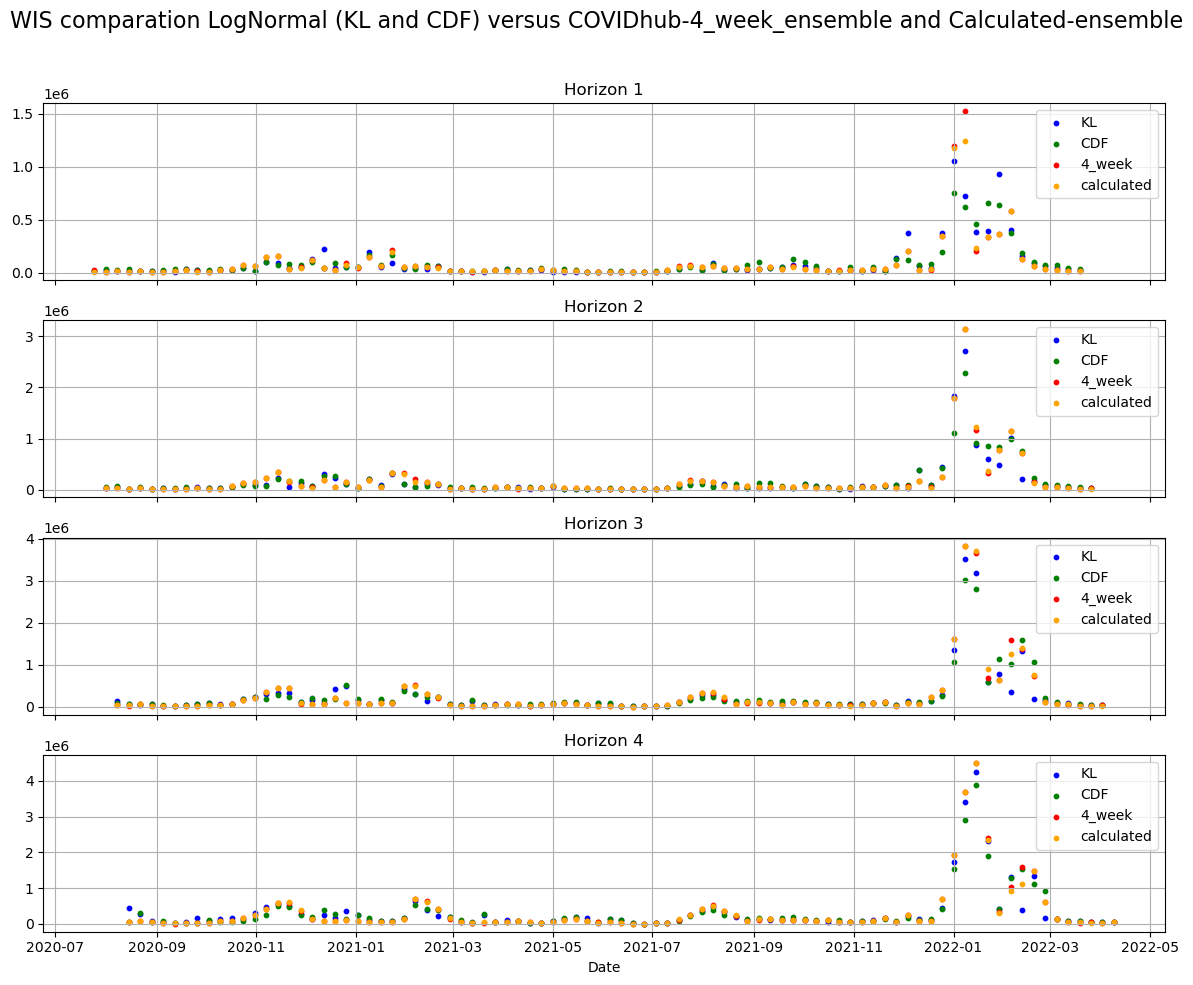

In [24]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('WIS comparation LogNormal (KL and CDF) versus COVIDhub-4_week_ensemble and Calculated-ensemble', fontsize=16)

for i, cat in enumerate([1, 2, 3, 4]):
    ax = axs[i]
    df_cat = merged_df[merged_df['horizon'] == cat]
    
    ax.scatter(df_cat['target_end_date'], df_cat['KL_WIS'], label='KL', color='blue', s=10)
    ax.scatter(df_cat['target_end_date'], df_cat['CDF_WIS'], label='CDF', color='green', s=10)
    ax.scatter(df_cat['target_end_date'], df_cat['wis_COVIDhub'], label='4_week', color='red', s=10)
    ax.scatter(df_cat['target_end_date'], df_cat['wis_calculated'], label='calculated', color='orange', s=10)

    
    ax.set_title(f'Horizon {cat}')
    ax.legend()
    ax.grid(True)

# Format x-axis
plt.xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.savefig('first_draft.png', dpi=300, bbox_inches='tight')
plt.show()

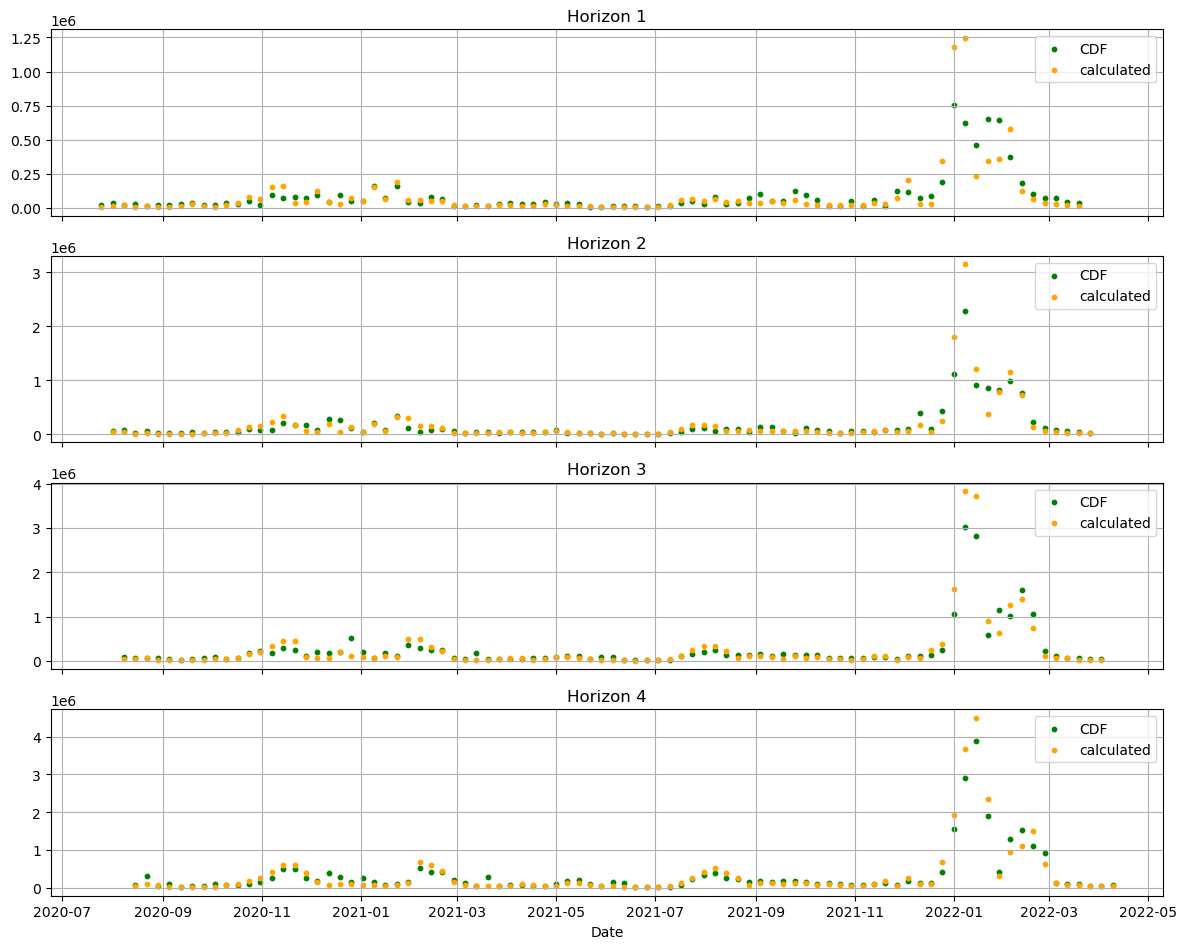

In [27]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

for i, cat in enumerate([1, 2, 3, 4]):
    ax = axs[i]
    df_cat = merged_df[merged_df['horizon'] == cat]
    
    #ax.scatter(df_cat['target_end_date'], df_cat['KL_WIS'], label='KL', color='blue', s=10)
    ax.scatter(df_cat['target_end_date'], df_cat['CDF_WIS'], label='CDF', color='green', s=10)
    #ax.scatter(df_cat['target_end_date'], df_cat['wis_COVIDhub'], label='4_week', color='red', s=10)
    ax.scatter(df_cat['target_end_date'], df_cat['wis_calculated'], label='calculated', color='orange', s=10)


    ax.set_title(f'Horizon {cat}')
    ax.legend()
    ax.grid(True)

# Format x-axis
plt.xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.savefig('second_draft.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
def summarize_columns(df, columns):
    summary = pd.DataFrame(columns=["Mean", "Std Dev", "Min", "25%", "Median", "75%", "Max", "Sum"])
    
    for col in columns:
        if col in df.columns:
            stats = {
                "Mean": df[col].mean(),
                "Std Dev": df[col].std(),
                "Min": df[col].min(),
                "25%": df[col].quantile(0.25),
                "Median": df[col].median(),
                "75%": df[col].quantile(0.75),
                "Max": df[col].max(),
                "Sum": df[col].sum()
            }
            summary.loc[col] = stats
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    print(summary.round(3))

summarize_columns(merged_df, ['CDF_WIS','KL_WIS','wis_COVIDhub','wis_calculated'])

                      Mean     Std Dev       Min        25%     Median  \
CDF_WIS         204539.356  430621.631  6222.982  39529.982  77241.763   
KL_WIS          202870.206  473935.429  4734.192  33959.466  70848.857   
wis_COVIDhub    213738.085  533066.945  4694.550  26978.854  58224.786   
wis_calculated  211329.286  527579.471  4578.466  27087.732  58575.606   

                       75%          Max           Sum  
CDF_WIS         166076.822  3893224.984  7.117970e+07  
KL_WIS          153864.682  4241799.721  7.059883e+07  
wis_COVIDhub    136356.488  4482429.507  7.438085e+07  
wis_calculated  137240.185  4500550.170  7.354259e+07  


In [27]:
merged_df.to_csv("results/merged_df_wis_cases.csv")